# Classification

A common problem when machine learning is used to classify data is when its is unbalanced. in front of this problems I applied balancing methods doing a oversampling and undersampling to compare the results in diferents classificators.

# Classification steps 

*   Extract the data from .data file
*   Show the data proportions graphically
*   Apply the balancing methods
*   Train the classificators
*   Test the classificators by cross validation
*   Evaluate the classificators results



# Results 

**Main functions**


In [0]:
import warnings
warnings.filterwarnings('ignore')
def analise(dtx,dty):
  X, y = (dtx,dty)
  loo = LeaveOneOut()
  print(type(X))
  h = .02 

  names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
          "Decision Tree", "Random Forest"
          , "Neural Net","Gaussian Process"
          ]

  classifiers = [KNeighborsClassifier(3),
      SVC(kernel="linear", C=0.025),
      SVC(gamma=2, C=1),
      DecisionTreeClassifier(max_depth=5),
      RandomForestClassifier(max_depth=5, n_estimators=6, max_features=1),
      MLPClassifier(alpha=1, max_iter=1000),
      GaussianProcessClassifier(1.0 * RBF(1.0))
      ]


  figure = plt.figure(figsize=(30, 5))

  X = StandardScaler().fit_transform(X)
  scoresT = []
  confusion_matrixT = []

  loo.get_n_splits(X)
  i = 1
  for name, classifier in zip(names, classifiers):
    ax = plt.subplot(1, 9, i)
    scores = []
    confusion_matrix = None

    True_P = []
    False_P = []
    y_pred_probability = []
    y_tested = []
    #aplicando Leave one out
    for cont, (train_index, test_index) in enumerate(loo.split(X)):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      model = classifier.fit(X_train,y_train)
      y_predict = model.predict(X_test)
      if cont == 0:
        confusion_matrix = metrics.confusion_matrix(y_test,y_predict,labels=[0, 1])
      else:
        confusion_matrix += metrics.confusion_matrix(y_test,y_predict,labels=[0, 1])
      scores.append(model.score(X_test, y_test))
      y_tested.append(y_test)
      if hasattr(model, "decision_function"):
        y_pred_probability.append(model.decision_function(X_test))
      else:
        y_pred_probability.append(model.predict_proba(X_test)[:,1])
      
    y_tested = np.array(y_tested)
    y_pred_probability = np.array(y_pred_probability)
    confusion_matrixT.append(confusion_matrix)
    scores = np.array(scores)
    scoresT.append([scores.mean(),scores.std()])
    accuracy = (confusion_matrix[0, 0]+confusion_matrix[1, 1])/(confusion_matrix.sum())
    ax = plt.subplot(1, 9, i)
    fpr, tpr, _ = metrics.roc_curve(y_tested,  y_pred_probability)
    auc = metrics.roc_auc_score(y_tested, y_pred_probability)
    ax.plot(fpr,tpr,label="data 1, auc="+str(('%.3f' % auc).lstrip('0')))
    ax.legend(loc=4)
    ax.set_title(name)
    i += 1
  plt.tight_layout()
  plt.show()
  
  #Mostrando matriz de confusão dos classificadores
  figure2 = plt.figure(figsize=(30, 12))
  for cont,matrix in enumerate(confusion_matrixT):
    ax = plt.subplot(1, 9, cont+1)
    im = ax.imshow(matrix)
    ax.set_title(names[cont])
    ax.axis('off')
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            text = ax.text(j, i, matrix[i, j],
                          ha="center", va="center", color="w")
  plt.tight_layout()
  plt.show()

  #acuracia = (TP+TN)/(TP+TN+FP+FN)
  #Precisao = TP/(TP+FP)
  #Recall = TP/(TP+FN)
  #F1 = (2*Precisao*Recall)/(Precisao+Recall)
  #Mostrando matriz com metricas
  figure3 = plt.figure(figsize=(30, 12))
  for cont,matrix in enumerate(confusion_matrixT):
    TP = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TN = matrix[1,1]

    Acuracia = (TP+TN)/(TP+TN+FP+FN)
    Precisao = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1 = (2*Precisao*Recall)/(Precisao+Recall)

    ax = plt.subplot(1, 9, cont+1)
    im = ax.imshow(matrix)
    ax.set_title(names[cont])
    ax.axis('off')
    texto = "Acuracia: \n"+str(('%.2f' % Acuracia))
    ax.text(0, 0, texto,ha="center", va="center", color="w")
    texto = "Precisao: \n"+str(('%.2f' % Precisao))
    ax.text(0, 1, texto,ha="center", va="center", color="w")
    texto = "Recall: \n"+str(('%.2f' % Recall))
    ax.text(1, 0, texto,ha="center", va="center", color="w")
    texto = "F1: \n"+str(('%.2f' % F1))
    ax.text(1, 1, texto,ha="center", va="center", color="w")
  plt.tight_layout()
  plt.show()

  return(figure,figure2,figure3)


In [0]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

**Extract the data from .data file**


In [0]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import preprocessing

F = open('column_2C.data','r')
dados=[]
value = F.read()
amostras = value.split('\n')
amostraN = 1

value = value.replace("AB","0")
value = value.replace("NO","1")
value = value.replace("\n",",")
value = value.replace(" ",",")
dados = value.split(',')
atributos = ["incidência pélvica", "inclinação pélvica", "ângulo da lordose lombar", "inclinação sacral", "raio pélvico", "grau de espondilolistese"]
classesNames = ["AB","NO"]
nClasses = 2


if '' in dados:
  dados.remove('')
  
if '' in amostras:
  amostras.remove('')

nAmostras = len(amostras)
nAtributos = int(len(dados)/len(amostras))
matrizDados = np.zeros((nAmostras,nAtributos))
classes = []
media = []
desvio = []
indX = indY = 0

for i in range(nAmostras):
  indX=0
  for y in range(nAtributos):
    
    matrizDados[indY,indX] = dados[(i*nAtributos+y)]
    indX+=1
   
  indY+=1

if amostraN == 2 or amostraN == 3:
  matrizDadosCP = matrizDados.copy()
  matrizDados[:,0:nAtributos-1] = matrizDadosCP[:,1:nAtributos]
  matrizDados[:,nAtributos-1] = matrizDadosCP[:,0]
  matrizDados[:,nAtributos-1] -= 1

In [0]:
Xdata = np.array([matrizDados[:,5], matrizDados[:,4]])
dts = [matrizDados[:,:6], matrizDados[:,6]] #Wine


**Show the data proportions graphically**

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Class 0: 210
Class 1: 100


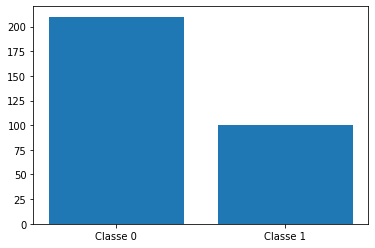

In [0]:
from imblearn.under_sampling import NearMiss
class0 = dts[0][dts[1]==0]
class1 = dts[0][dts[1]==1]

target_count = [len(class0),len(class1)]
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
plott = plt.bar([0,1], target_count)
plt.xticks([0,1], ('Classe 0', 'Classe 1'))
plt.show()



**Apply the balancing methods**

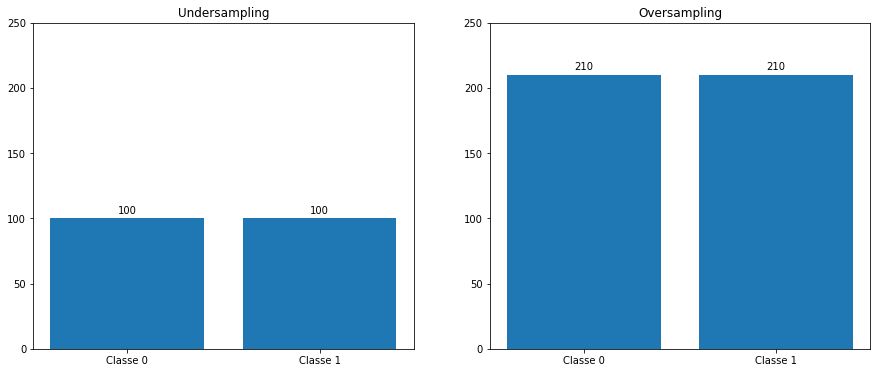

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn import metrics 
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

X, y = dts

nm1 = NearMiss(version=1)

tl = TomekLinks()
X_undersampled, y_undersampled = tl.fit_resample(X, y)
X_undersampled, y_undersampled = nm1.fit_resample(X, y)

X_oversampled, y_oversampled = SMOTE().fit_resample(X, y)
figure = plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 2, 1)
class0 = X_undersampled[y_undersampled==0]
class1 = X_undersampled[y_undersampled==1]

target_count = [len(class0),len(class1)]
plot1 = plt.bar([0,1], target_count)
plt.xticks([0,1], ('Classe 0', 'Classe 1'))
ax.set_ylim(0, 250)
ax.set_title("Undersampling")
autolabel(plot1)
ax = plt.subplot(1, 2, 2)
class0 = X_oversampled[y_oversampled==0]
class1 = X_oversampled[y_oversampled==1]

target_count = [len(class0),len(class1)]
plot2 = plt.bar([0,1], target_count)
plt.xticks([0,1], ('Classe 0', 'Classe 1'))
ax.set_ylim(0, 250)
ax.set_title("Oversampling")
autolabel(plot2)
plt.show()

**Train the classificators(Unbalanced datas)**

--------------------------------Dados Desbalanceados-----------------------------------
<class 'numpy.ndarray'>


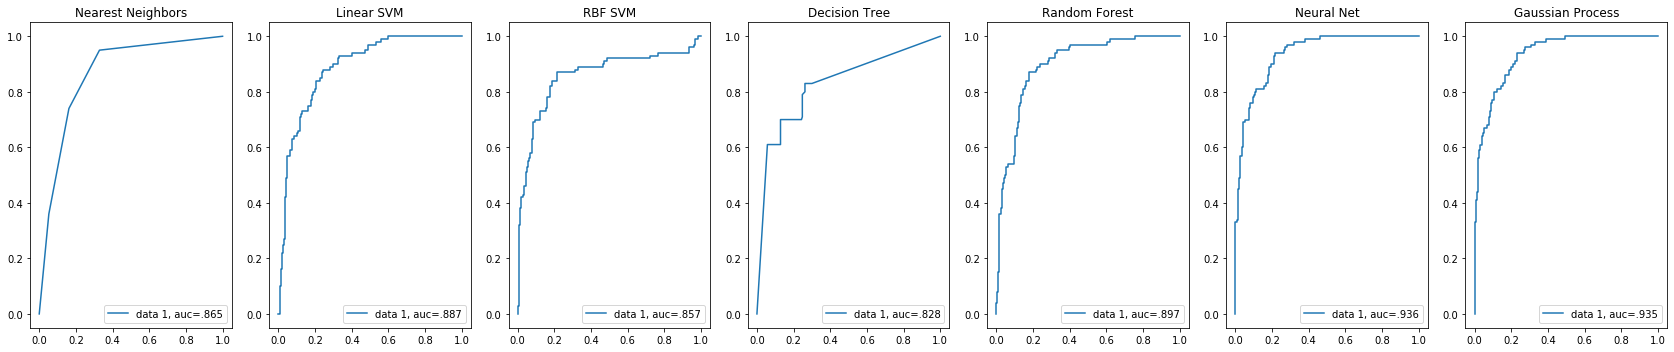

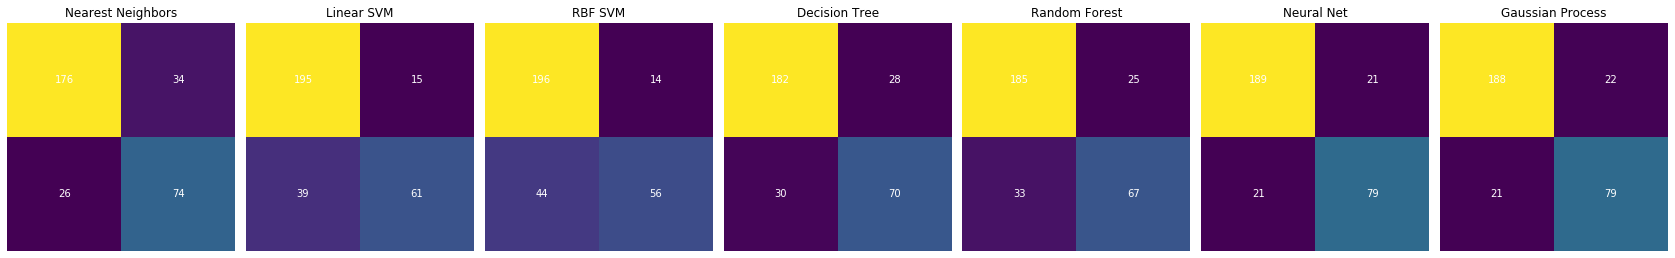

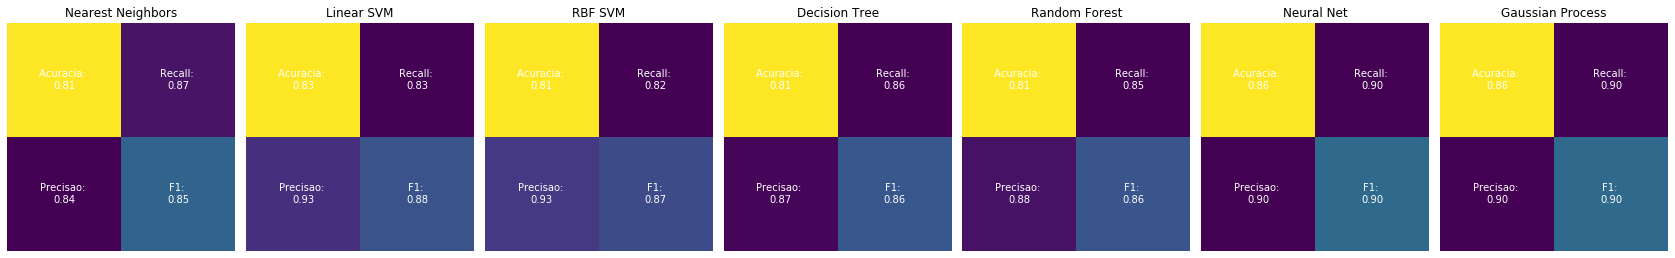

In [0]:
print("--------------------------------Dados Desbalanceados-----------------------------------")

fg, fg2, fg3 = analise(X,y)

**Train the classificators(undersampling datas)**

--------------------------------Dados Balanceados(Undersampling)-----------------------------------


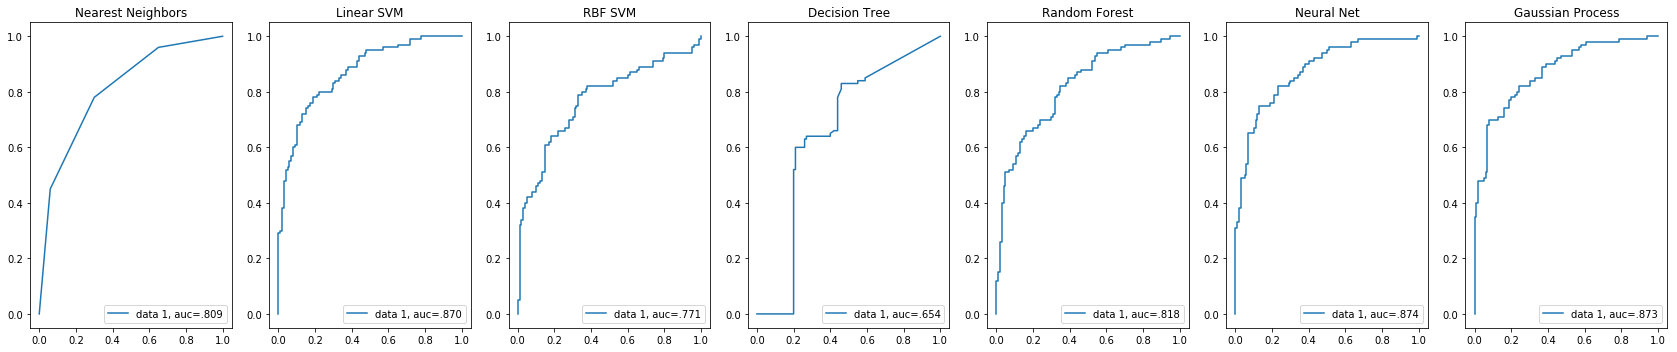

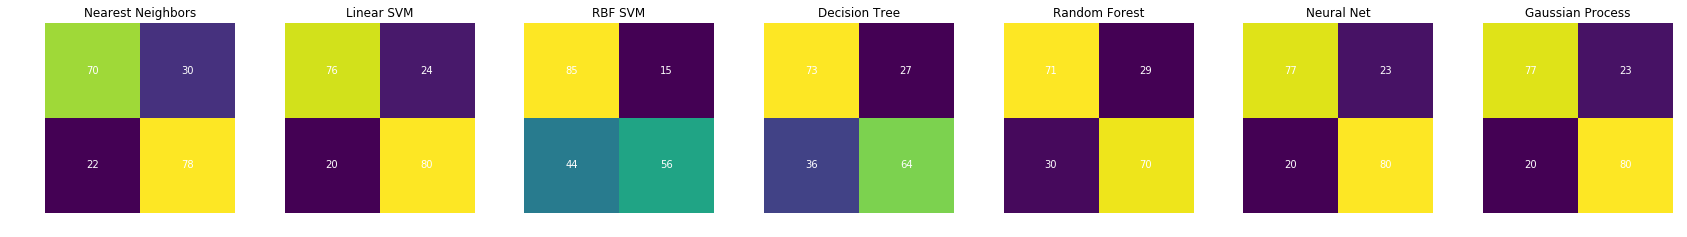

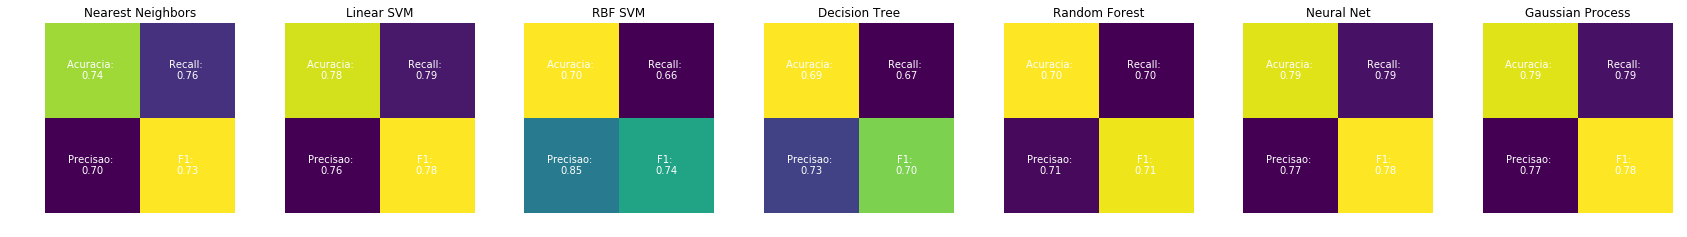

In [0]:
print("--------------------------------Dados Balanceados(Undersampling)-----------------------------------")
Underfg, Underfg2, Underfg3 = analise(X_undersampled, y_undersampled)


**Train the classificators(oversampling datas)**

--------------------------------Dados Balanceados(Oversampling)-----------------------------------


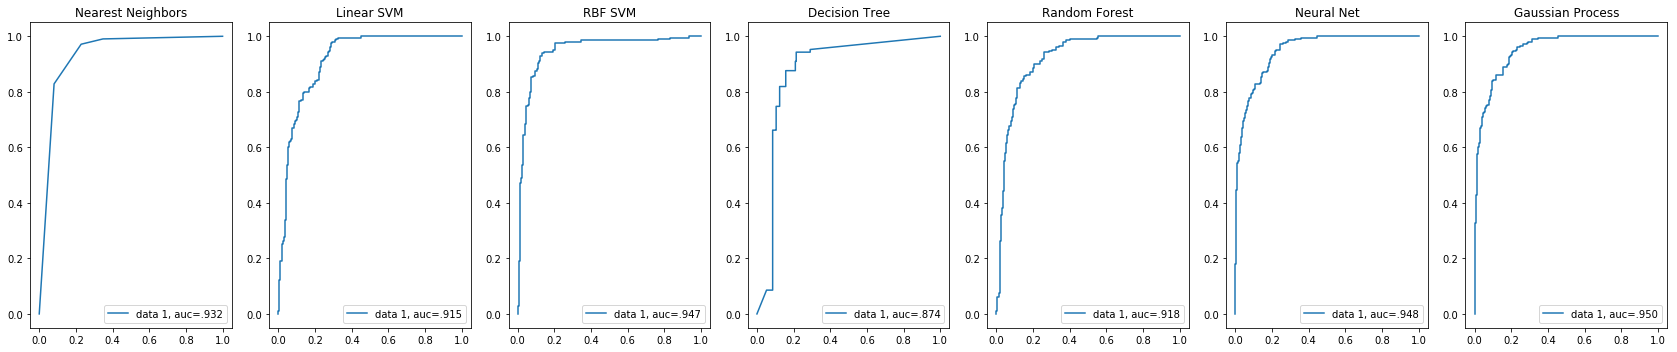

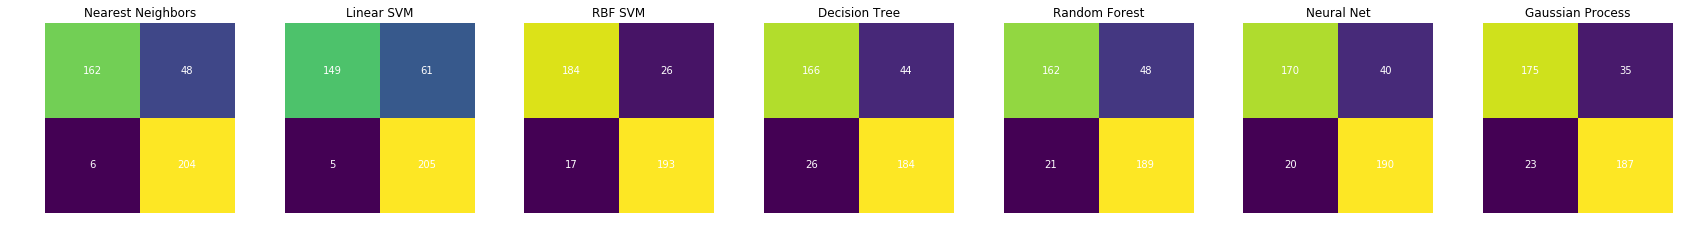

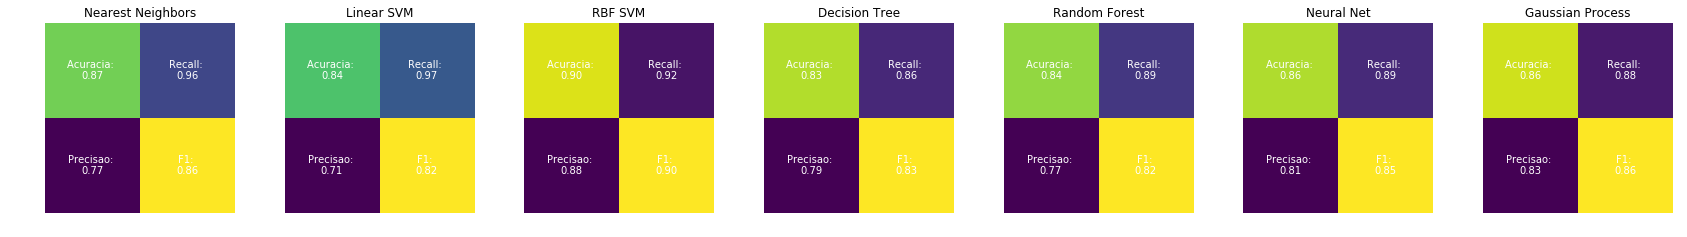

In [0]:
print("--------------------------------Dados Balanceados(Oversampling)-----------------------------------")
Overfg, Overfg2, Overfg3 = analise(X_oversampled, y_oversampled)

**Comparing the results**

--------------------------------Dados Desbalanceados-----------------------------------


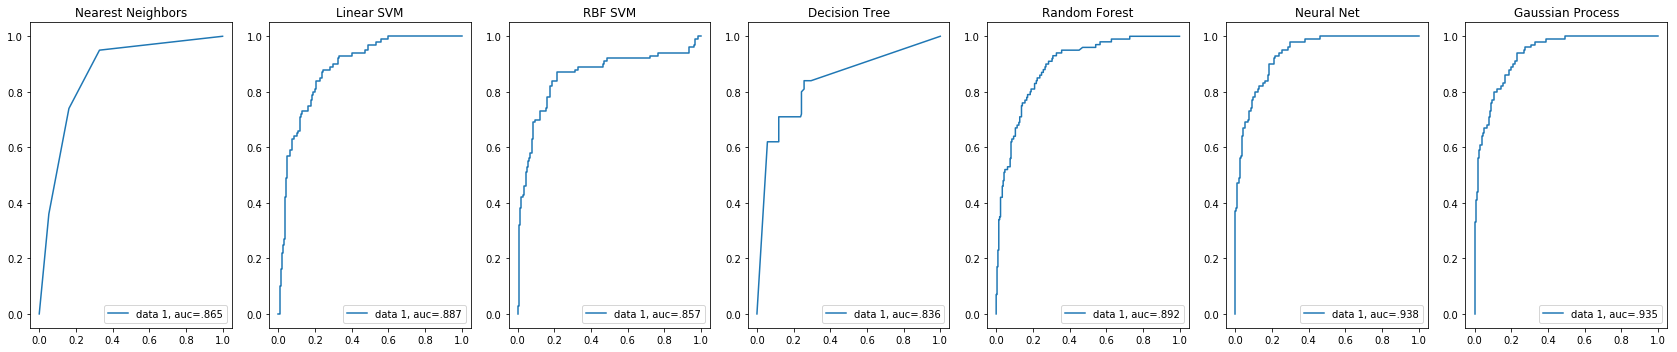

In [0]:
print("--------------------------------Dados Desbalanceados-----------------------------------")
fg


--------------------------------Dados Balanceados(Undersampling)-----------------------------------


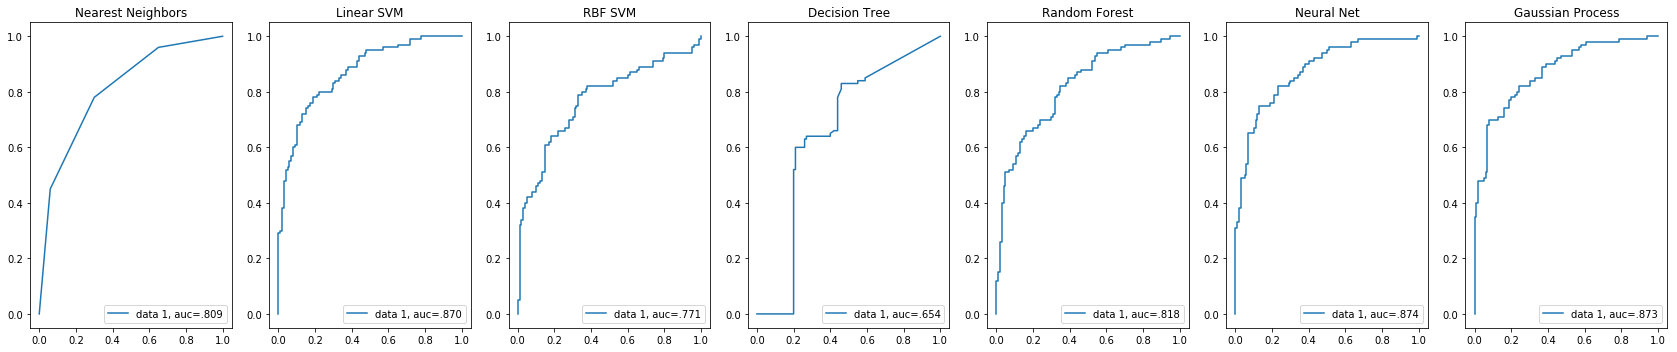

In [0]:

print("--------------------------------Dados Balanceados(Undersampling)-----------------------------------")
Underfg


--------------------------------Dados Balanceados(Oversampling)-----------------------------------


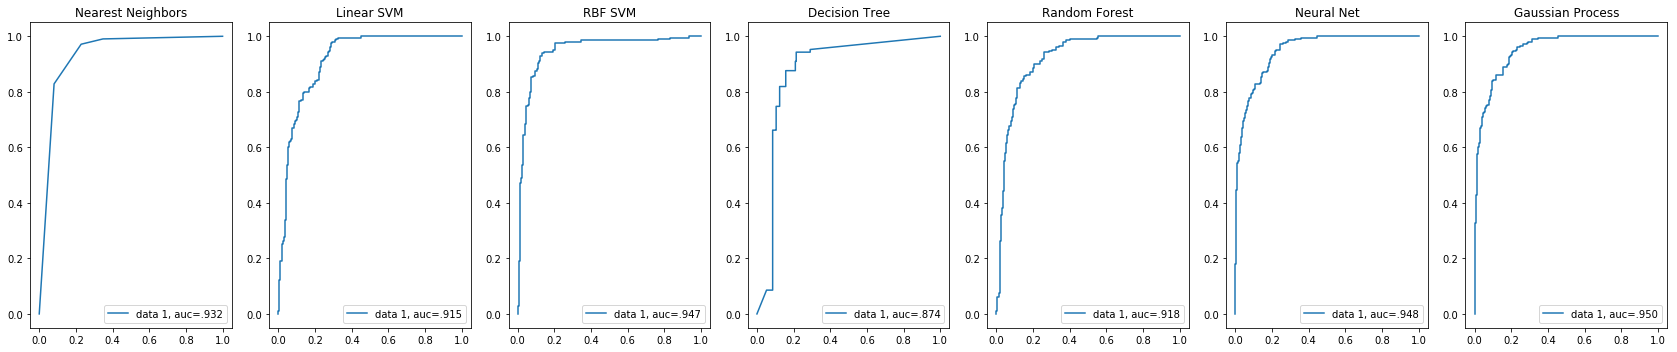

In [0]:
print("--------------------------------Dados Balanceados(Oversampling)-----------------------------------")
Overfg

--------------------------------Dados Desbalanceados-----------------------------------


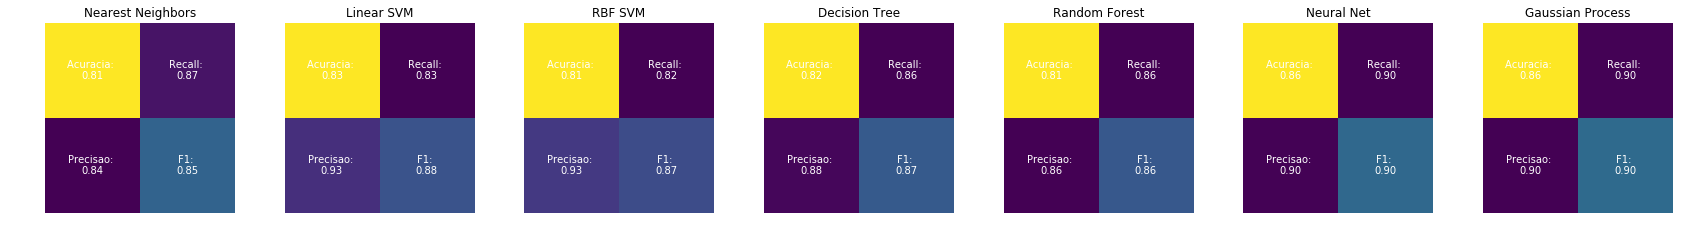

In [0]:
print("--------------------------------Dados Desbalanceados-----------------------------------")
fg3


--------------------------------Dados Balanceados(Undersampling)-----------------------------------


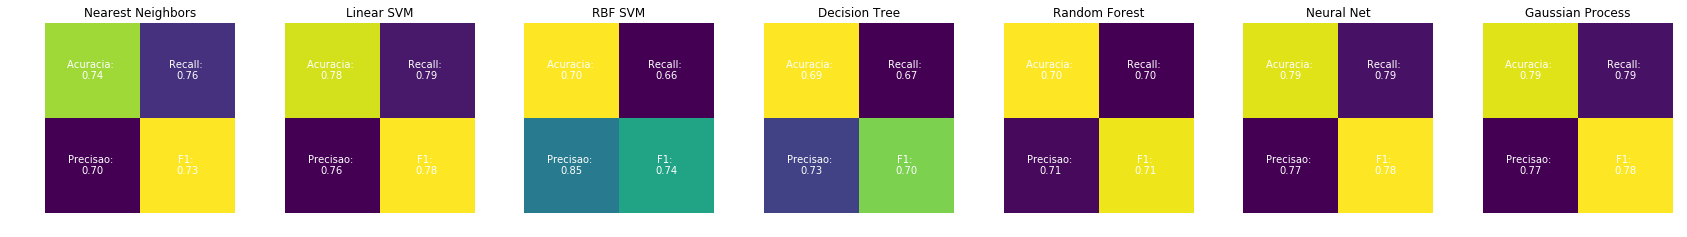

In [0]:
print("--------------------------------Dados Balanceados(Undersampling)-----------------------------------")
Underfg3


--------------------------------Dados Balanceados(Oversampling)-----------------------------------


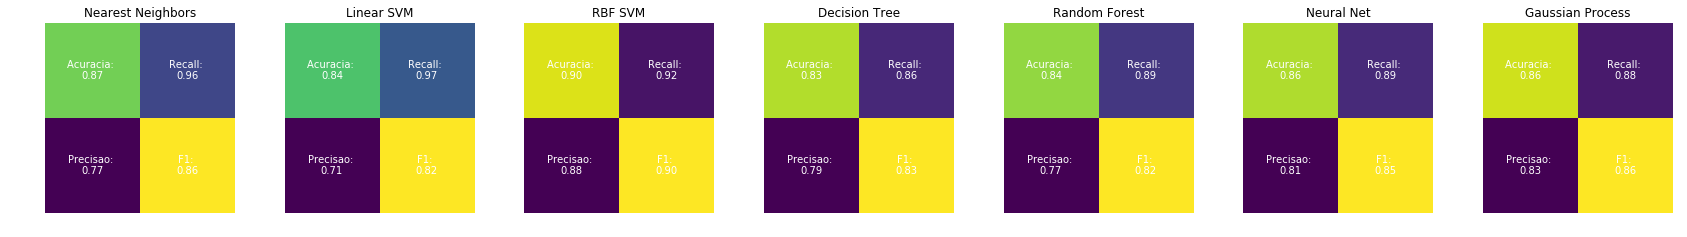

In [0]:
print("--------------------------------Dados Balanceados(Oversampling)-----------------------------------")
Overfg3